# Gathering seeing data

I had some discussions with [Miguel Rodríguez Alarcon (IAC)](https://scholar.google.com/citations?user=ySJtt44AAAAJ&hl=es&oi=ao) to discuss the best way to measure and keep track of seeing. 
* He discouraged me from using from using FWHM from images, as this parameter will combine astronomical seeing effects with instrumental seeing. 
* He suggested using the DIMM sensors available throughout the institute. 
* He suggested the idea of observing if variability in DIMM seeing is directly translated into higher FWHM in the images and, therefore, if FWHM can be used for atmospheric-only seeing (i.e. if instrumental seeing is more or less constant).

## Sources of DIMM seeing
* ING - WHTR2D2, accessible via <https://astro.ing.iac.es/seeing/r2d2_data.php>
* TNG - FGC-DIMM, I don't find access to raw data via web.

### Gathering data from R2D2

In [14]:
from aspred.connector import r2d2_seeing
from datetime import datetime
import pandas as pd

initial_date = datetime(2024, 1, 1)
final_date = datetime(2024, 5, 20)

df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-01-01&date2=2024-05-20&submit=Submit...
Data retrieved successfully


<Axes: ylabel='Density'>

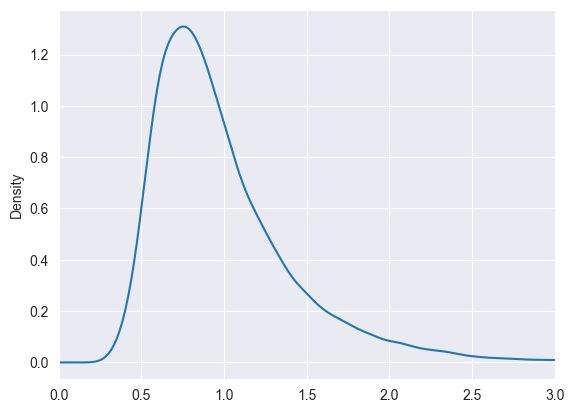

In [15]:
df["Seeing"].plot.kde(xlim=(0, 3))

* Question 1: what's the relation between the calibrated seeing during the photometric pipeline (FWHM), and the DIMM-measured seeing?
* Question 2: how close are TNG and ING seeing measurements?
* Question 3: how can the seeing be predicted from weather data?

## Getting data from LT headers

In [16]:
from aspred.connector import query_from_lt_header
import aspred.utils
import datetime

# Initial date

initial_date_mjd = aspred.utils.datetime_to_mjd(initial_date)
final_date_mjd = aspred.utils.datetime_to_mjd(final_date)

query = """SELECT mjd, AGFWHM, L1SEESEC FROM allkeys WHERE INSTRUME = "IO:O" AND AGFWHM != 0 AND mjd > """ + str(initial_date_mjd) + " AND mjd < " + str(final_date_mjd) + " ORDER BY mjd ASC"
df2 = query_from_lt_header(query)
df2["date"] = df2["mjd"].apply(aspred.utils.mjd_to_datetime)

print(len(df2), "rows")

15899 rows


/Users/fabarzuza/Documents/GitHub/aspred/aspred/connector.py:162: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(query, mydb)


In [17]:
df2

mjd  AGFWHM   L1SEESEC                       date
0      60310.005234   2.063    1.37555 2024-01-01 00:07:32.217600
1      60310.005756   2.063    1.13058 2024-01-01 00:08:17.318400
2      60310.006292   2.063    1.51499 2024-01-01 00:09:03.628800
3      60310.007329   2.063    1.45452 2024-01-01 00:10:33.225600
4      60310.007816   2.063    1.22453 2024-01-01 00:11:15.302400
...             ...     ...        ...                        ...
15894  60424.234737   2.694  999.00000 2024-04-24 05:38:01.276800
15895  60424.240471   2.694  999.00000 2024-04-24 05:46:16.694400
15896  60424.240801   2.694  999.00000 2024-04-24 05:46:45.206400
15897  60424.241203   2.694  999.00000 2024-04-24 05:47:19.939200
15898  60424.241533   2.694  999.00000 2024-04-24 05:47:48.451200

[15899 rows x 4 columns]

In [18]:
# Remove outliers with FWHM > 2
limit = 4
df2 = df2[df2["L1SEESEC"] < limit]
df = df[df["Seeing"] < limit]

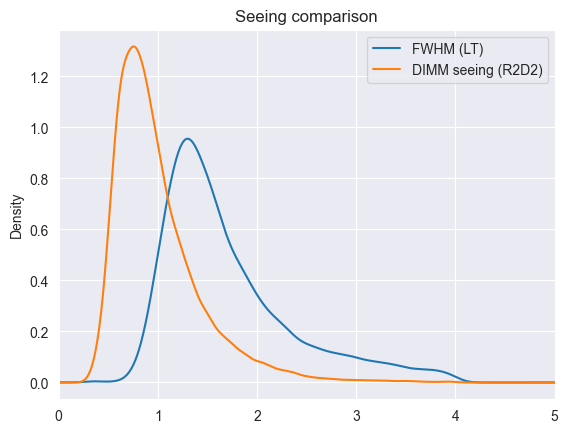

In [19]:
import matplotlib.pyplot as plt
df2["L1SEESEC"].plot.kde(xlim=(0, limit+1), label="FWHM (LT)")
df["Seeing"].plot.kde(xlim=(0, limit+1), label="DIMM seeing (R2D2)")
plt.title("Seeing comparison")
plt.legend()

In [20]:
# Creates a dataframe with 10 minute intervals from the initial date to the last date
date_range = pd.date_range(start=initial_date, end=final_date, freq="10min")

In [21]:
r2d2_list = []
fwhm_list = []
date_list = []

# Loop through the date range and calculate the average seeing (R2D2 and FWHM) for each interval
for i, date in enumerate(date_range):
    print(i, "out of ", len(date_range), end="\r")
    # Add exception for last date
    if i == len(date_range) - 1:
        continue
    # Find r2d2 seeing between this date and the next one
    r2d2_seeing = df[(df["Date"] >= date) & (df["Date"] < date_range[i+1])]["Seeing"]
    # Calculate average seeing for that interval
    r2d2_seeing_mean = r2d2_seeing.mean()
    # Find FWHM between this date and the next one
    fwhm = df2[(df2["date"] >= date) & (df2["date"] < date_range[i+1])]["L1SEESEC"]
    # Calculate average FWHM for that interval
    fwhm_mean = fwhm.mean()
    # Append to the lists
    r2d2_list.append(r2d2_seeing_mean)
    fwhm_list.append(fwhm_mean)
    date_list.append(date)
    

In [22]:
# Create dataframe with lists
df3 = pd.DataFrame({"date": date_list, "r2d2_seeing": r2d2_list, "fwhm_seeing": fwhm_list})
# Remove any rows that contains NaN in either column
df3 = df3.dropna()

Text(0.5, 1.0, 'Seeing comparison')

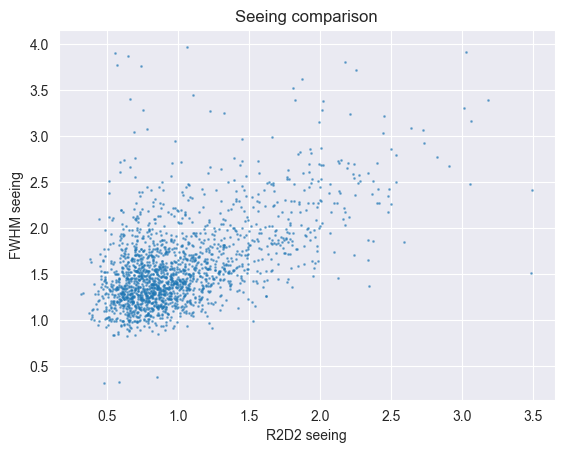

In [23]:
#Plot r2d2 seeing vs FWHM seeing
plt.scatter(df3["r2d2_seeing"], df3["fwhm_seeing"], alpha=0.5, s=1)
plt.xlabel("R2D2 seeing")
plt.ylabel("FWHM seeing")
plt.title("Seeing comparison")

In [24]:
# Find and assess correlation and linear fit
import numpy as np
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df3["r2d2_seeing"], df3["fwhm_seeing"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)




Slope: 0.5848235297801809
Intercept: 0.9861094625257849
R value: 0.5547590065425088
P value: 3.0389510135368787e-151
Standard error: 0.020304568681414024


Text(0.5, 1.0, 'Seeing comparison')

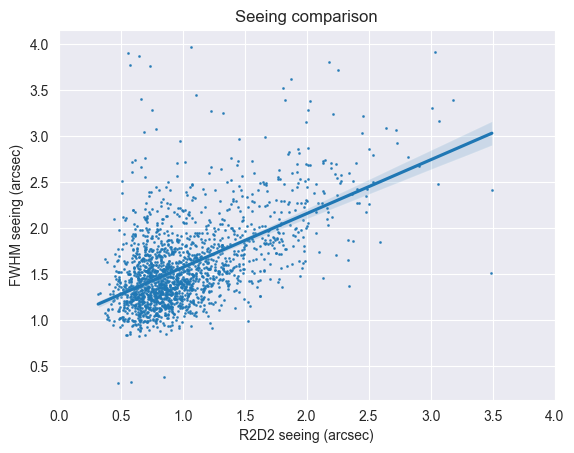

In [27]:
# Plot r2d2 seeing vs FWHM seeing with correlation line
import seaborn as sns
sns.regplot(x="r2d2_seeing", y="fwhm_seeing", data=df3, scatter_kws={"s": 1})
plt.xlim(0,4)
plt.xlabel("R2D2 seeing (arcsec)")
plt.ylabel("FWHM seeing (arcsec)")
plt.title("Seeing comparison")

Conclusion: there is no relation between the seeing measured by the DIMM sensor and the seeing measured by the FWHM in the images.


# Predicting seeing

In [62]:
#Fetch NRT data from InfluxDB
from influxdb_client import InfluxDBClient
import pandas as pd
host = 'https://influxdb.services.newrobotictelescope.org'
username = "nrt-admin"
password = "super_secret_password"
ssl = True
verify_ssl = True
token = "YNZ0oOiejxQT62BXkLyuQfTvH8su0ki9oMbv12l3VU7kwpUvk8NE_SSp10geFA6vKFg8TQMAd8y82tK2UtCVSg=="
org = "NRT"
bucket = "Weatherstation"

client = InfluxDBClient(host, token, org, timeout = 60000)
print('alive: %s' % client.ping())


query = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-12T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  """

query2 = """from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-12T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

mean_table = |> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
stddev_table = |> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> map(fn: (r) => ({ _time: r._time, _field: "wind_speed_avg_stddev", _value: r._value }))

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")"""

query3 = """
mean_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-12T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "relative_humidity" or r["_field"] == "wind_direction_avg" or r["_field"] == "wind_speed_avg" or r["_field"] == "wind_speed_max")
|> aggregateWindow(every: 30m, fn: mean, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

stddev_table = from(bucket: "Weatherstation")
|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-12T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "weatherstation")
|> filter(fn: (r) => r["_field"] == "wind_speed_avg")
|> aggregateWindow(every: 30m, fn: stddev, createEmpty: false)
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

join(tables: {mean: mean_table, stddev: stddev_table}, on: ["_time"])
|> drop(columns: ["_start", "_stop"])
"""
system_stats = client.query_api().query_data_frame(query3, org)


>>> Request: 'GET https://influxdb.services.newrobotictelescope.org/ping?'
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Content-Type: application/json
>>> Body: None
<<< Response: 204
<<< X-Influxdb-Build: OSS
<<< X-Influxdb-Version: v2.3.0+SNAPSHOT.090f681737
<<< Date: Wed, 19 Jun 2024 10:43:17 GMT
<<< Via: 1.1 google
<<< Alt-Svc: h3=":443"; ma=2592000,h3-29=":443"; ma=2592000
<<< Body: 
alive: True
>>> Request: 'POST https://influxdb.services.newrobotictelescope.org/api/v2/query?org=NRT'
>>> Accept: application/json
>>> Content-Type: application/json
>>> Authorization: ***
>>> User-Agent: influxdb-client-python/1.43.0
>>> Body: {'extern': {'imports': [], 'body': []}, 'query': '\nmean_table = from(bucket: "Weatherstation")\n|> range(start: 2024-02-07T00:00:00Z, stop: 2024-06-12T00:00:00Z)\n|> filter(fn: (r) => r["_measurement"] == "weatherstation")\n|> filter(fn: (r) => r["_field"] == "air_pressure" or r["_field"] == "air_temperature" or r["_field"] == "rel

In [72]:
weather_data = system_stats[["_time", "air_pressure", "air_temperature", "relative_humidity", "wind_direction_avg", "wind_speed_avg_mean", "wind_speed_max", "wind_speed_avg_stddev"]]
weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_67923/987057805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data["time"] = weather_data["_time"].dt.tz_localize(None)


In [66]:
weather_data

_time  air_pressure  air_temperature  \
0    2024-02-07 09:00:00+00:00    778.300000         7.200000   
1    2024-02-07 09:30:00+00:00    778.372414         8.548276   
2    2024-02-07 10:00:00+00:00    778.580000         9.288000   
3    2024-02-07 10:30:00+00:00    778.580000         9.136667   
4    2024-02-07 11:00:00+00:00    778.641379         9.541379   
...                        ...           ...              ...   
6021 2024-06-11 22:00:00+00:00    776.443333        11.070000   
6022 2024-06-11 22:30:00+00:00    776.579310        10.675862   
6023 2024-06-11 23:00:00+00:00    776.843333        10.613333   
6024 2024-06-11 23:30:00+00:00    776.986207        10.648276   
6025 2024-06-12 00:00:00+00:00    776.896667        10.983333   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
0              8.400000          192.000000             3.000000   
1              5.127586          180.068966             3.906897   
2              5.044000          166.480000             2.744000   
3              7.533333          155.600000             3.110000   
4              9.865517          151.034483             2.720690   
...                 ...                 ...                  ...   
6021          10.913333           37.466667             3.523333   
6022          12.862069           44.172414             3.103448   
6023          12.370000           67.866667             1.816667   
6024          12.368966           53.275862             2.303448   
6025          11.246667           37.933333             3.450000   

      wind_speed_max  wind_speed_avg_stddev                time  
0           4.200000                    NaN 2024-02-07 09:00:00  
1           5.048276               0.780078 2024-02-07 09:30:00  
2           3.404000               0.501730 2024-02-07 10:00:00  
3           4.313333               0.562231 2024-02-07 10:30:00  
4           3.568966               0.581488 2024-02-07 11:00:00  
...              ...                    ...                 ...  
6021        6.770000               0.849618 2024-06-11 22:00:00  
6022        6.041379               0.646685 2024-06-11 22:30:00  
6023        3.980000               0.605198 2024-06-11 23:00:00  
6024        4.420690               0.642252 2024-06-11 23:30:00  
6025        5.833333               0.739408 2024-06-12 00:00:00  

[6026 rows x 9 columns]

In [67]:
from aspred.connector import r2d2_seeing
from datetime import datetime
initial_date = datetime(2024, 2, 14)
final_date = datetime(2024, 6, 12)
df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-02-14&date2=2024-06-12&submit=Submit...
Data retrieved successfully


In [68]:
df

Date  Seeing
0     2024-02-14 00:00:03  0.7877
1     2024-02-14 00:01:01  0.8162
2     2024-02-14 00:01:04  1.1646
3     2024-02-14 00:02:02  1.0125
4     2024-02-14 00:02:05  1.1152
...                   ...     ...
39638 2024-06-11 22:55:03  0.7241
39639 2024-06-11 22:56:02  0.9298
39640 2024-06-11 22:57:02  0.9208
39641 2024-06-11 22:58:01  0.7789
39642 2024-06-11 22:59:01  0.5982

[39643 rows x 2 columns]

In [69]:
# Add seeing into weather_data, calculating average for time intervals
import numpy as np

seeing_list = []
date_list = []
for i, date in enumerate(weather_data["time"]):
    print(i, "out of ", len(weather_data["_time"]), end="\r")
    if i == len(weather_data["_time"]) - 1:
        continue
    seeing = df[(df["Date"] >= date) & (df["Date"] < weather_data["time"][i+1])]["Seeing"]
    seeing_mean = seeing.mean()
    seeing_list.append(seeing_mean)
    date_list.append(date)
seeing_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [73]:
# Remove last row from weather dataframe and add seeing
weather_data = weather_data[:-1]
weather_data["seeing"] = seeing_list

clean_weather_data = weather_data.dropna()

In [74]:
clean_weather_data

_time  air_pressure  air_temperature  \
318  2024-02-14 00:00:00+00:00    772.603333         9.056667   
319  2024-02-14 00:30:00+00:00    772.337931         8.955172   
320  2024-02-14 01:00:00+00:00    772.143333         8.610000   
321  2024-02-14 01:30:00+00:00    771.865517         8.379310   
322  2024-02-14 02:00:00+00:00    771.596552         8.000000   
...                        ...           ...              ...   
6018 2024-06-11 20:30:00+00:00    775.862069        10.227586   
6019 2024-06-11 21:00:00+00:00    776.103333        10.406667   
6020 2024-06-11 21:30:00+00:00    776.289286        10.896429   
6021 2024-06-11 22:00:00+00:00    776.443333        11.070000   
6022 2024-06-11 22:30:00+00:00    776.579310        10.675862   

      relative_humidity  wind_direction_avg  wind_speed_avg_mean  \
318           42.336667          187.200000             2.626667   
319           40.924138          183.103448             3.313793   
320           43.926667          186.533333             2.730000   
321           45.151724          171.000000             2.365517   
322           46.965517          208.000000             1.955172   
...                 ...                 ...                  ...   
6018          14.358621          196.034483             4.434483   
6019          13.493333           53.300000             4.180000   
6020          11.225000           20.714286             4.567857   
6021          10.913333           37.466667             3.523333   
6022          12.862069           44.172414             3.103448   

      wind_speed_max  wind_speed_avg_stddev                time    seeing  
318         4.833333               0.869773 2024-02-14 00:00:00  1.212482  
319         5.441379               0.856790 2024-02-14 00:30:00  0.799742  
320         5.080000               0.690402 2024-02-14 01:00:00  0.652777  
321         5.317241               0.668301 2024-02-14 01:30:00  0.571277  
322         4.541379               0.528871 2024-02-14 02:00:00  0.713094  
...              ...                    ...                 ...       ...  
6018        6.924138               0.548554 2024-06-11 20:30:00  0.668966  
6019        7.150000               0.794116 2024-06-11 21:00:00  0.721109  
6020        8.046429               0.827783 2024-06-11 21:30:00  0.781600  
6021        6.770000               0.849618 2024-06-11 22:00:00  1.090094  
6022        6.041379               0.646685 2024-06-11 22:30:00  0.917560  

[1452 rows x 10 columns]

# Unsuperised learning

In [75]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = clean_weather_data.drop(columns=['seeing', '_time', 'time'])
y = clean_weather_data['seeing']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [76]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new dataframe with the PCA results
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['seeing'] = y.values


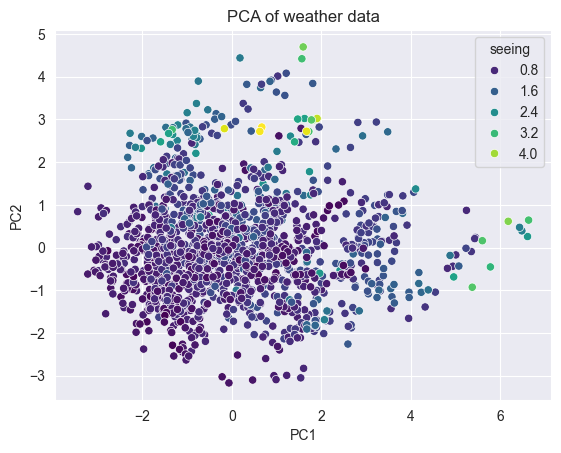

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='seeing', palette='viridis')
plt.title('PCA of weather data')
plt.show()


In [78]:
from sklearn.cluster import KMeans

# Choose the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_pca['Cluster'] = clusters


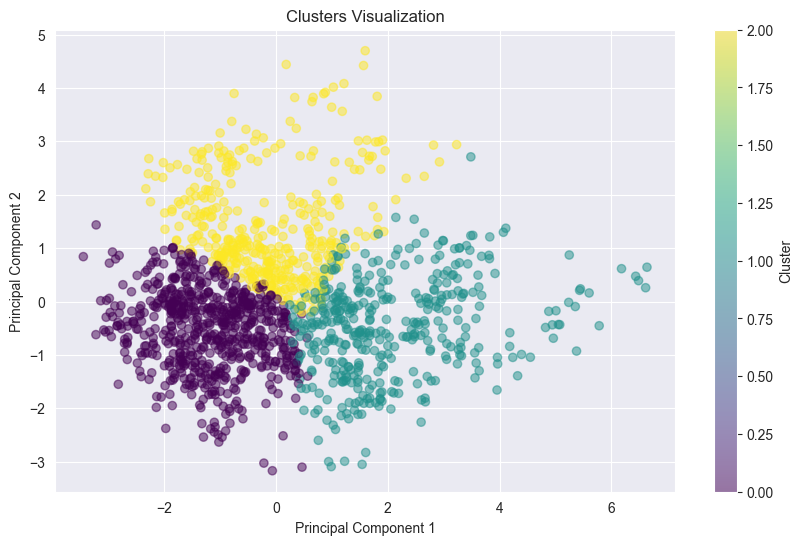

Cluster 0:
count    653.000000
mean       0.788155
std        0.215650
min        0.334666
25%        0.643470
50%        0.748566
75%        0.897728
max        2.030556
Name: seeing, dtype: float64


Cluster 1:
count    404.000000
mean       1.063733
std        0.494474
min        0.375253
25%        0.776407
50%        0.968622
75%        1.215962
max        4.484700
Name: seeing, dtype: float64


Cluster 2:
count    395.000000
mean       1.342648
std        0.656259
min        0.494447
25%        0.870971
50%        1.211222
75%        1.624274
max        4.584267
Name: seeing, dtype: float64




In [79]:
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Analyze the distribution of "seeing" in each cluster
for cluster in df_pca['Cluster'].unique():
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data['seeing'].describe())
    print('\n')


# Supervised learning

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [81]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [82]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 0.13941110091776804
R2 Score: 0.620813817430671


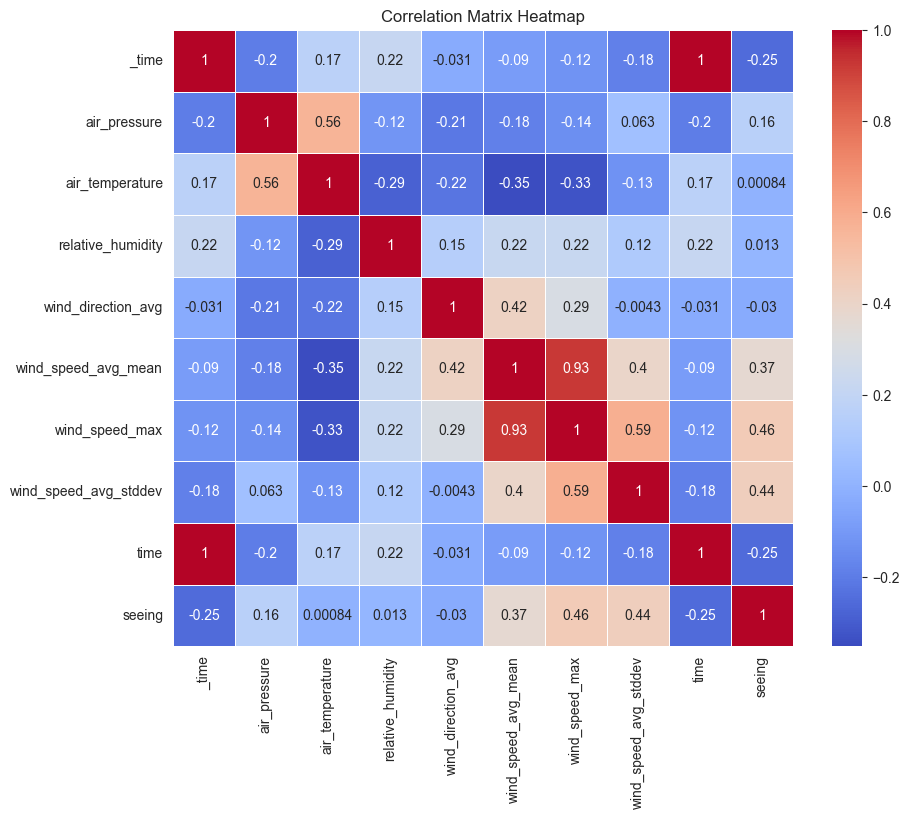

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = clean_weather_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


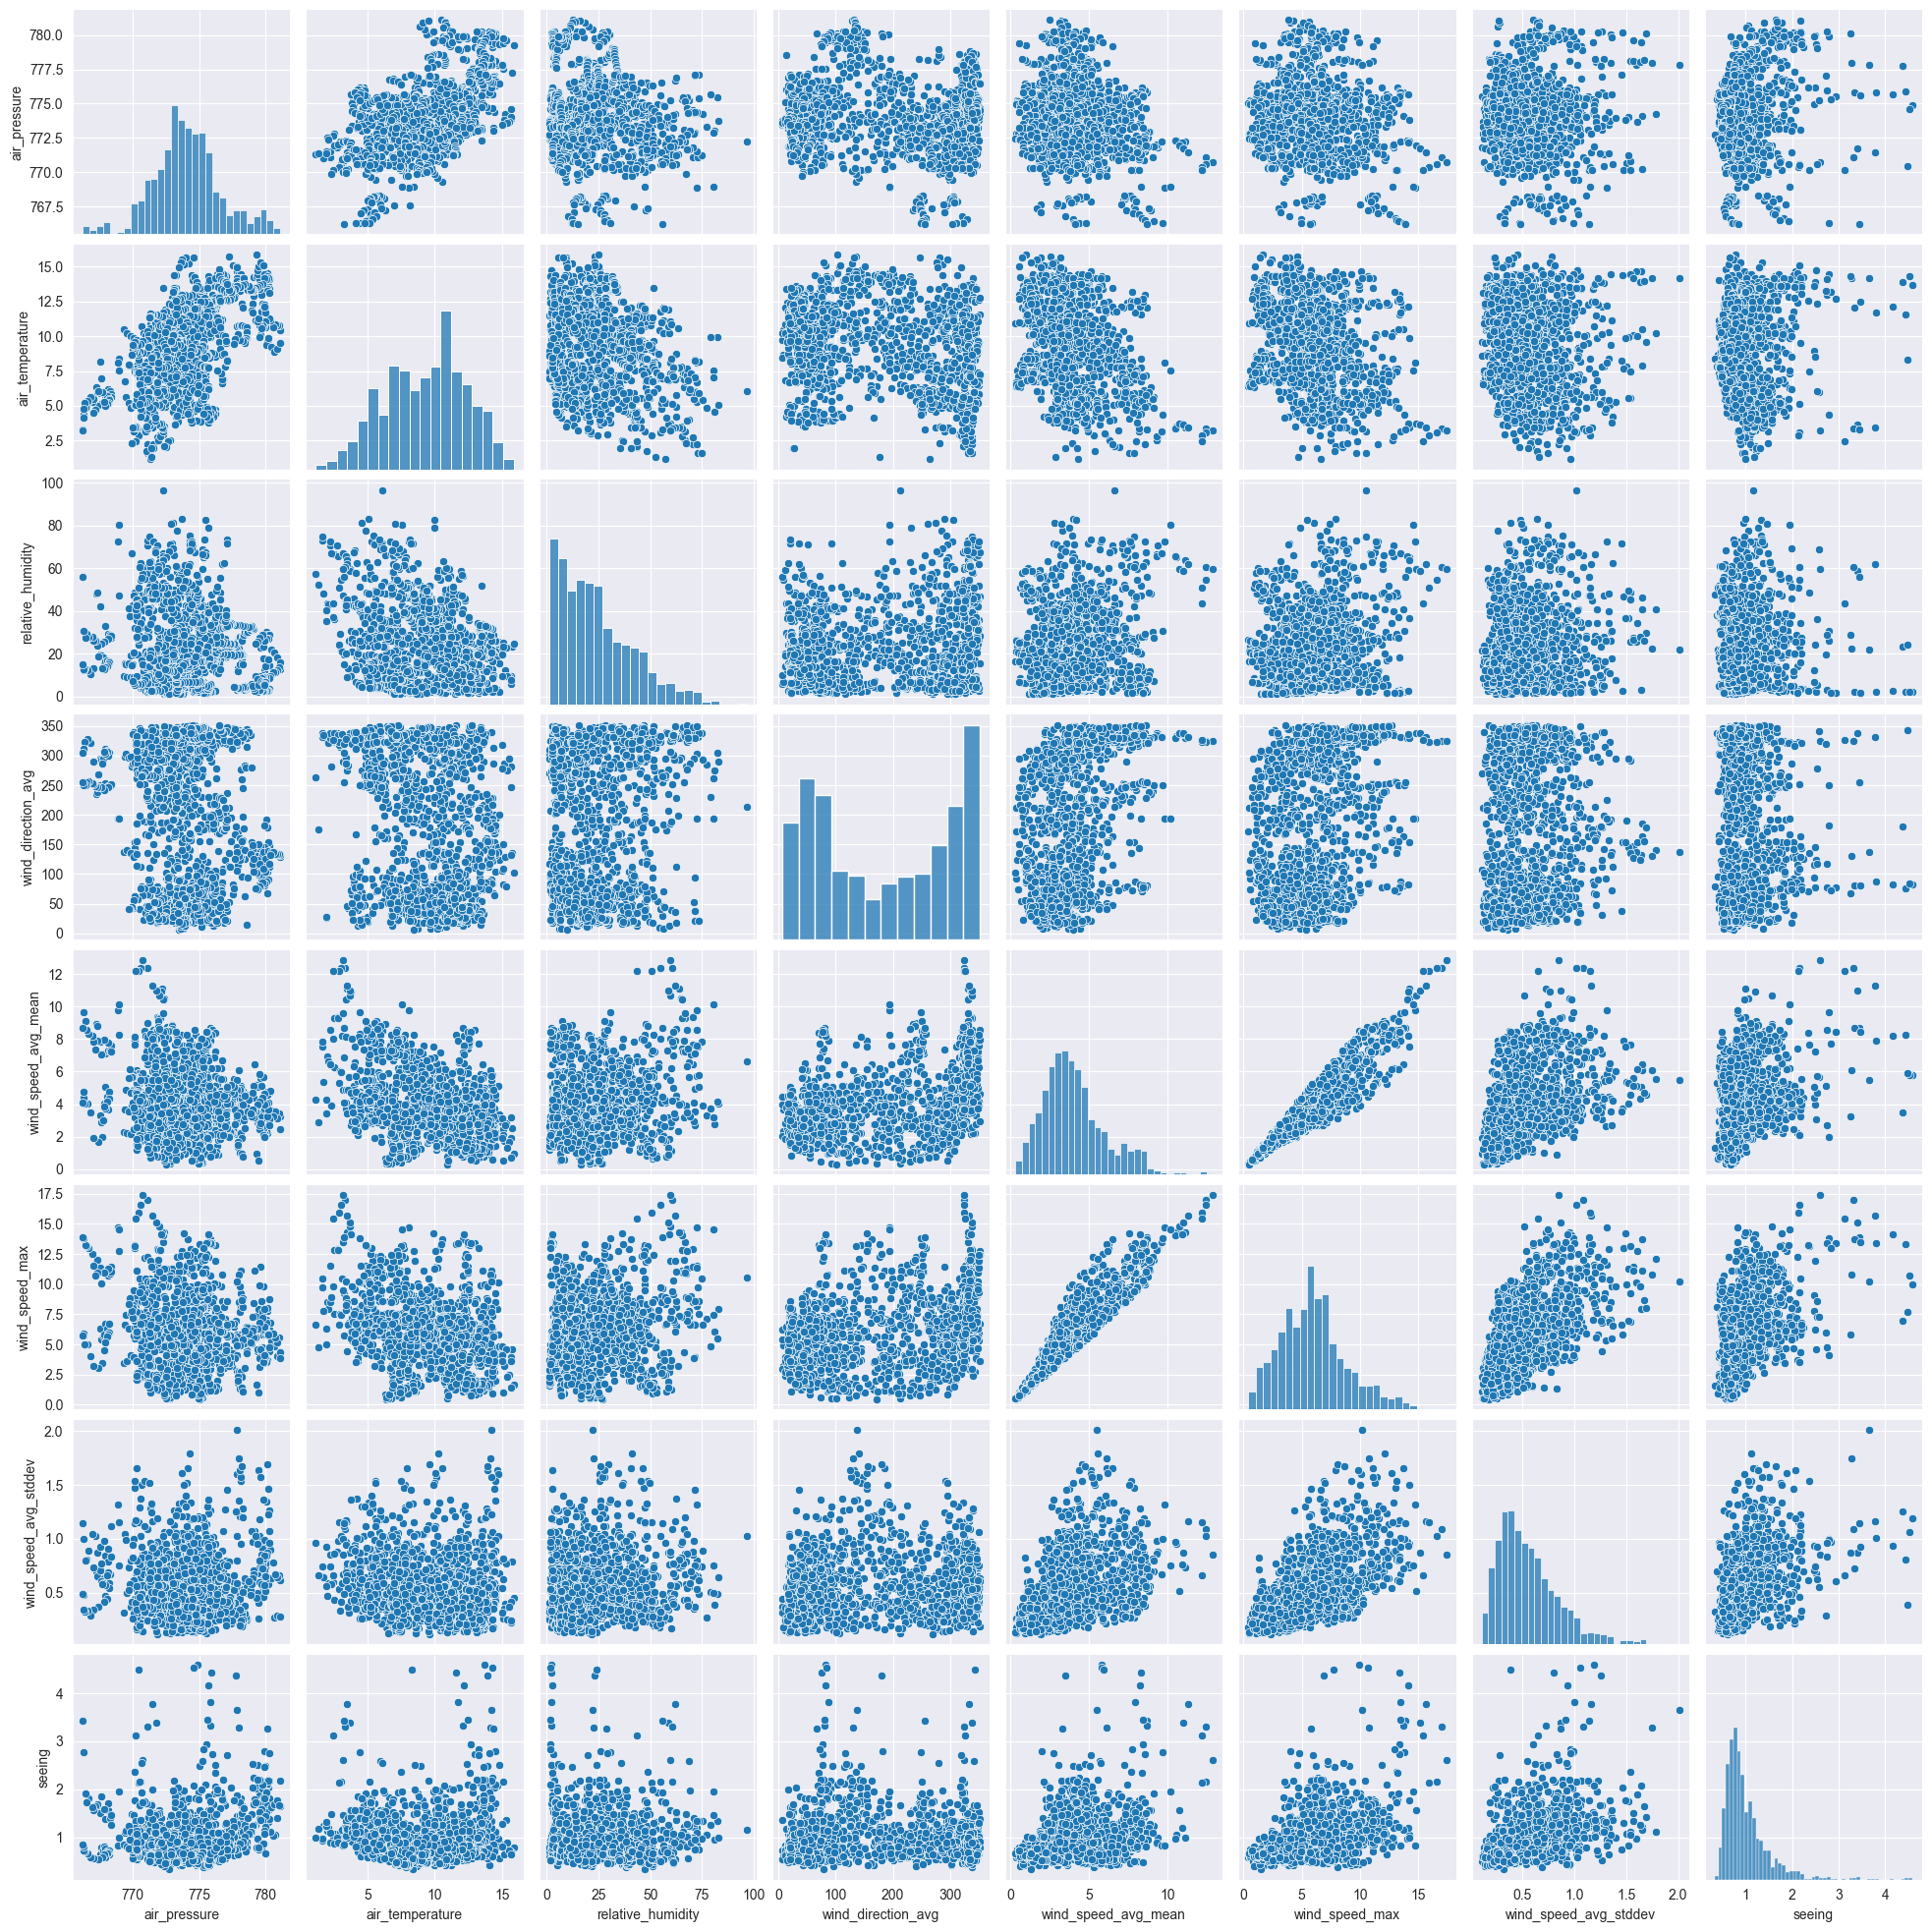

In [84]:
sns.pairplot(clean_weather_data)
plt.show()

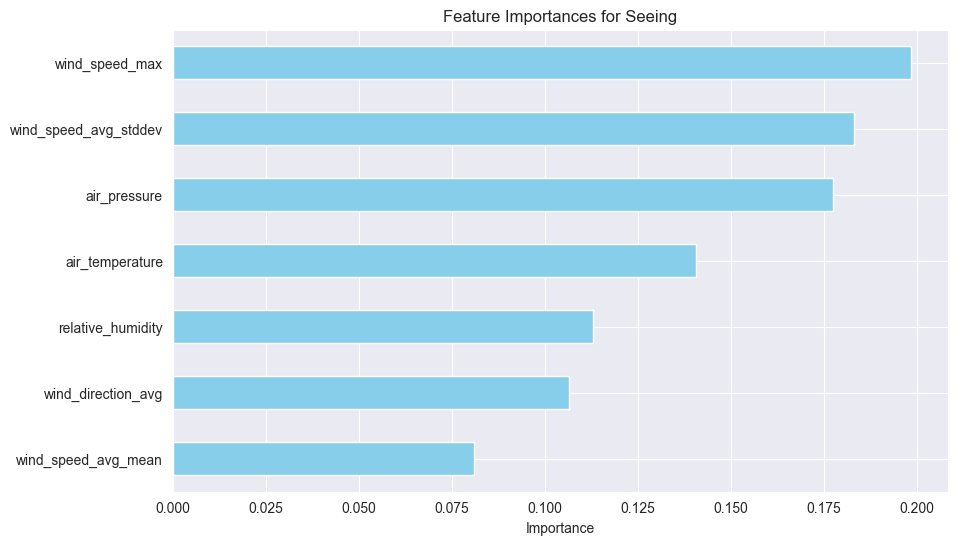

In [85]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot feature importances
sorted_importances = feature_importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importances for Seeing')
plt.xlabel('Importance')
plt.show()



In [87]:
# Create a new column with the predicted seeing
clean_weather_data['seeing_predicted'] = model.predict(X_scaled)

/var/folders/6r/4fgw_d4j3h17pk5bq1w2dqcw0000gn/T/ipykernel_67923/2529860354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_weather_data['seeing_predicted'] = model.predict(X_scaled)


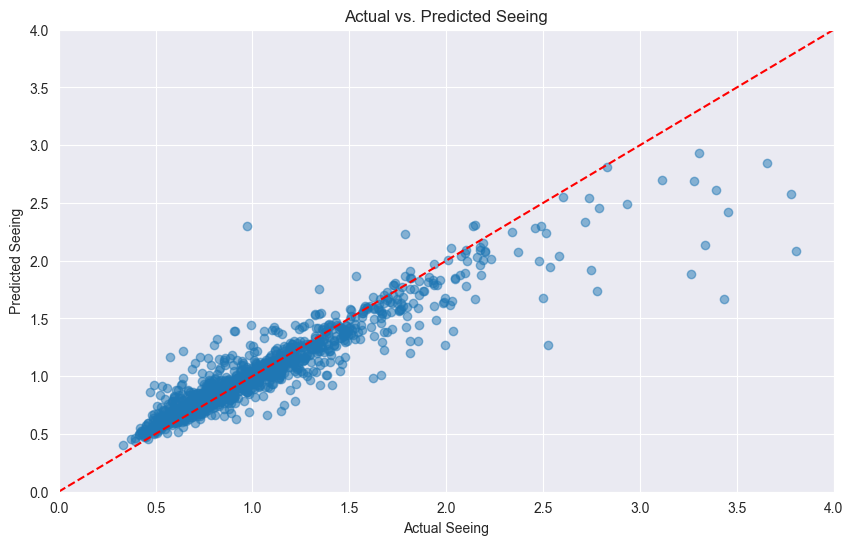

In [96]:
# Plot the actual vs. predicted seeing with linear regression, r squared, and p value
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.scatter(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'], alpha=0.5)
plt.plot([0, 4], [0, 4], color='red', linestyle='--')
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.xlabel('Actual Seeing')
plt.ylabel('Predicted Seeing')
plt.title('Actual vs. Predicted Seeing')
plt.show()

In [97]:
# We print the r correlation and the p parameter
slope, intercept, r_value, p_value, std_err = linregress(clean_weather_data['seeing'], clean_weather_data['seeing_predicted'])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)

Slope: 0.725470011146339
Intercept: 0.2662456309649007
R value: 0.933391127040862
P value: 0.0
Standard error: 0.007324832512308894
